In [1]:
from prevalence import plot_prevalence

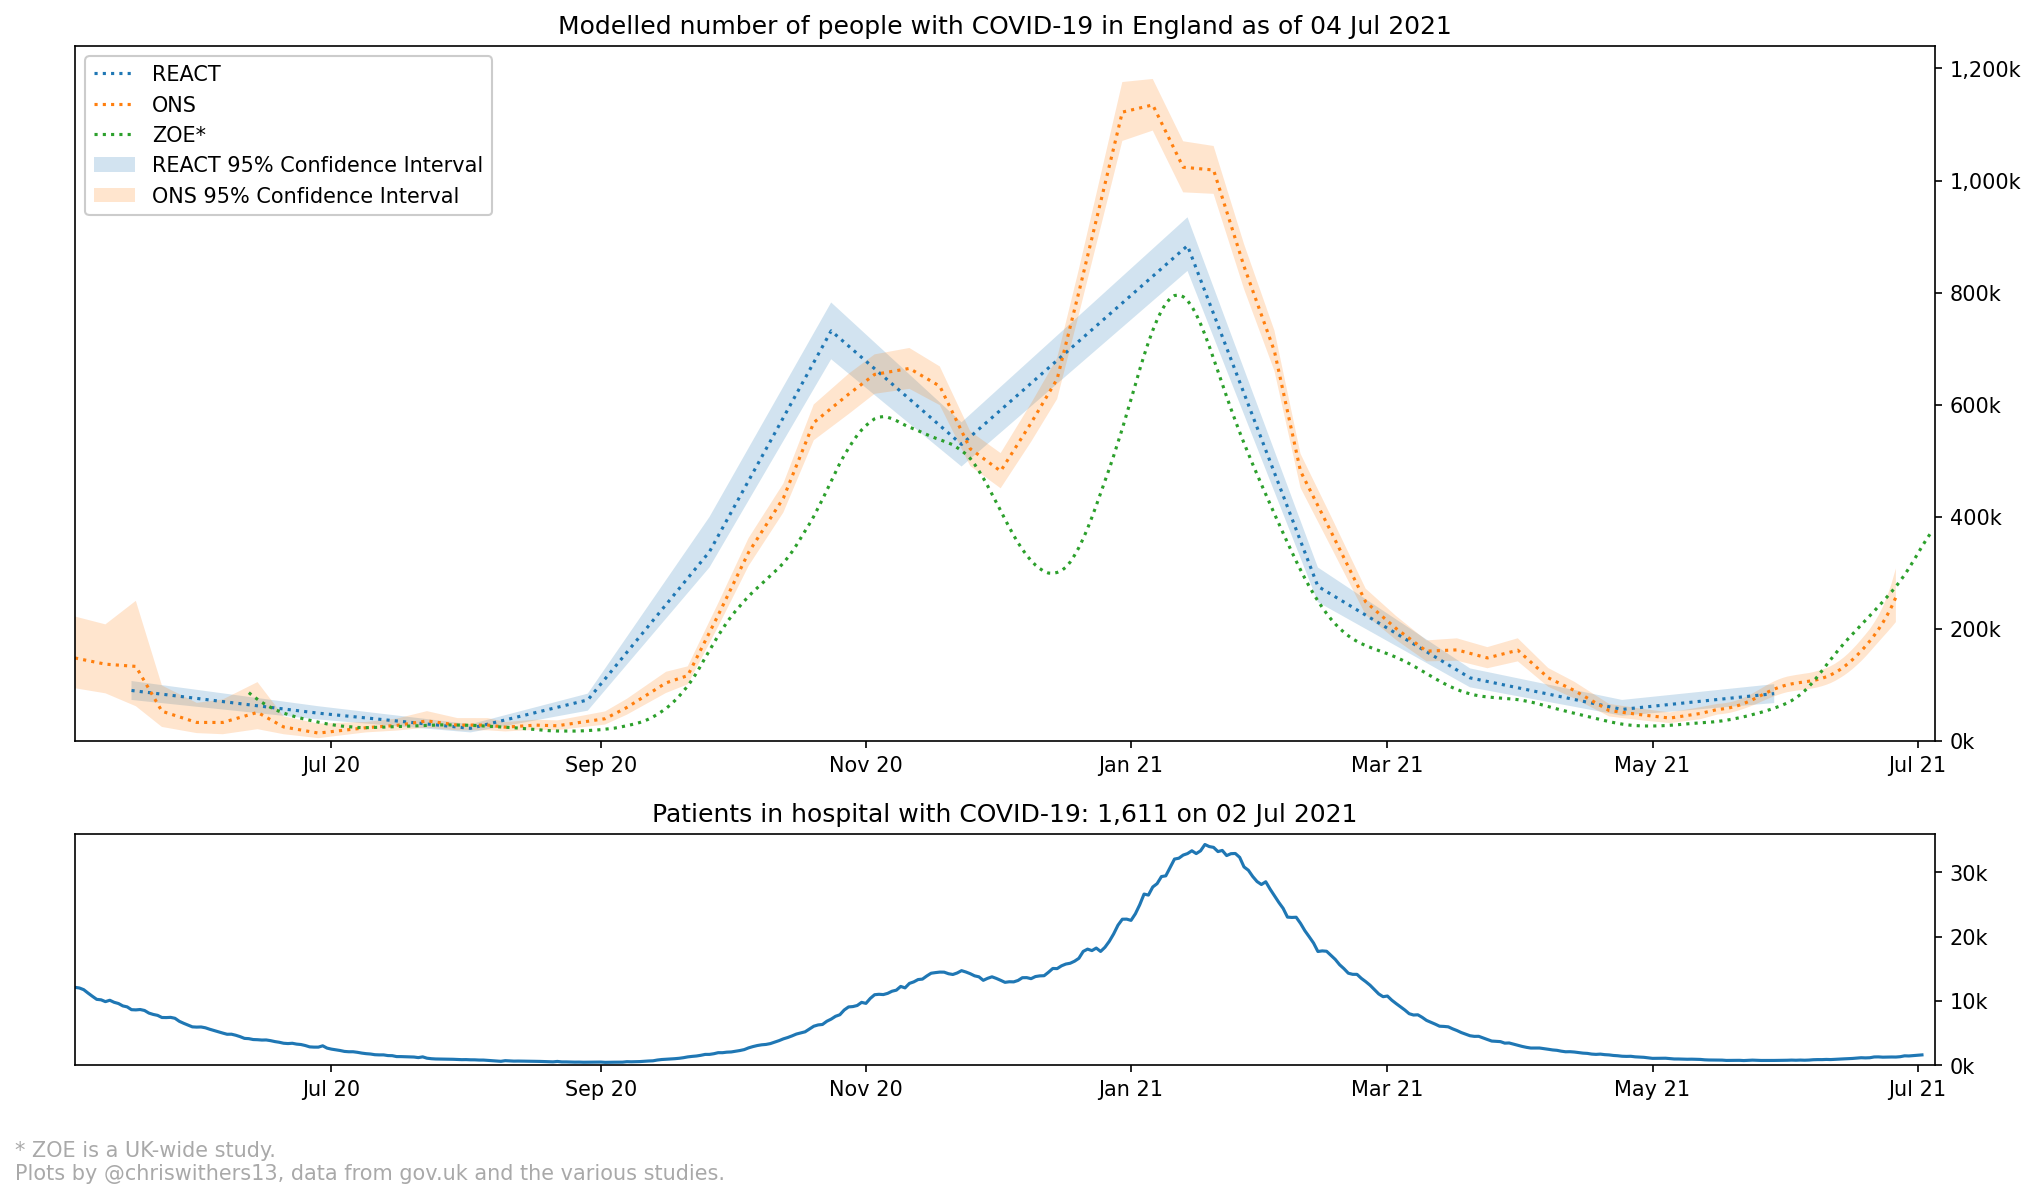

In [2]:
plot_prevalence()

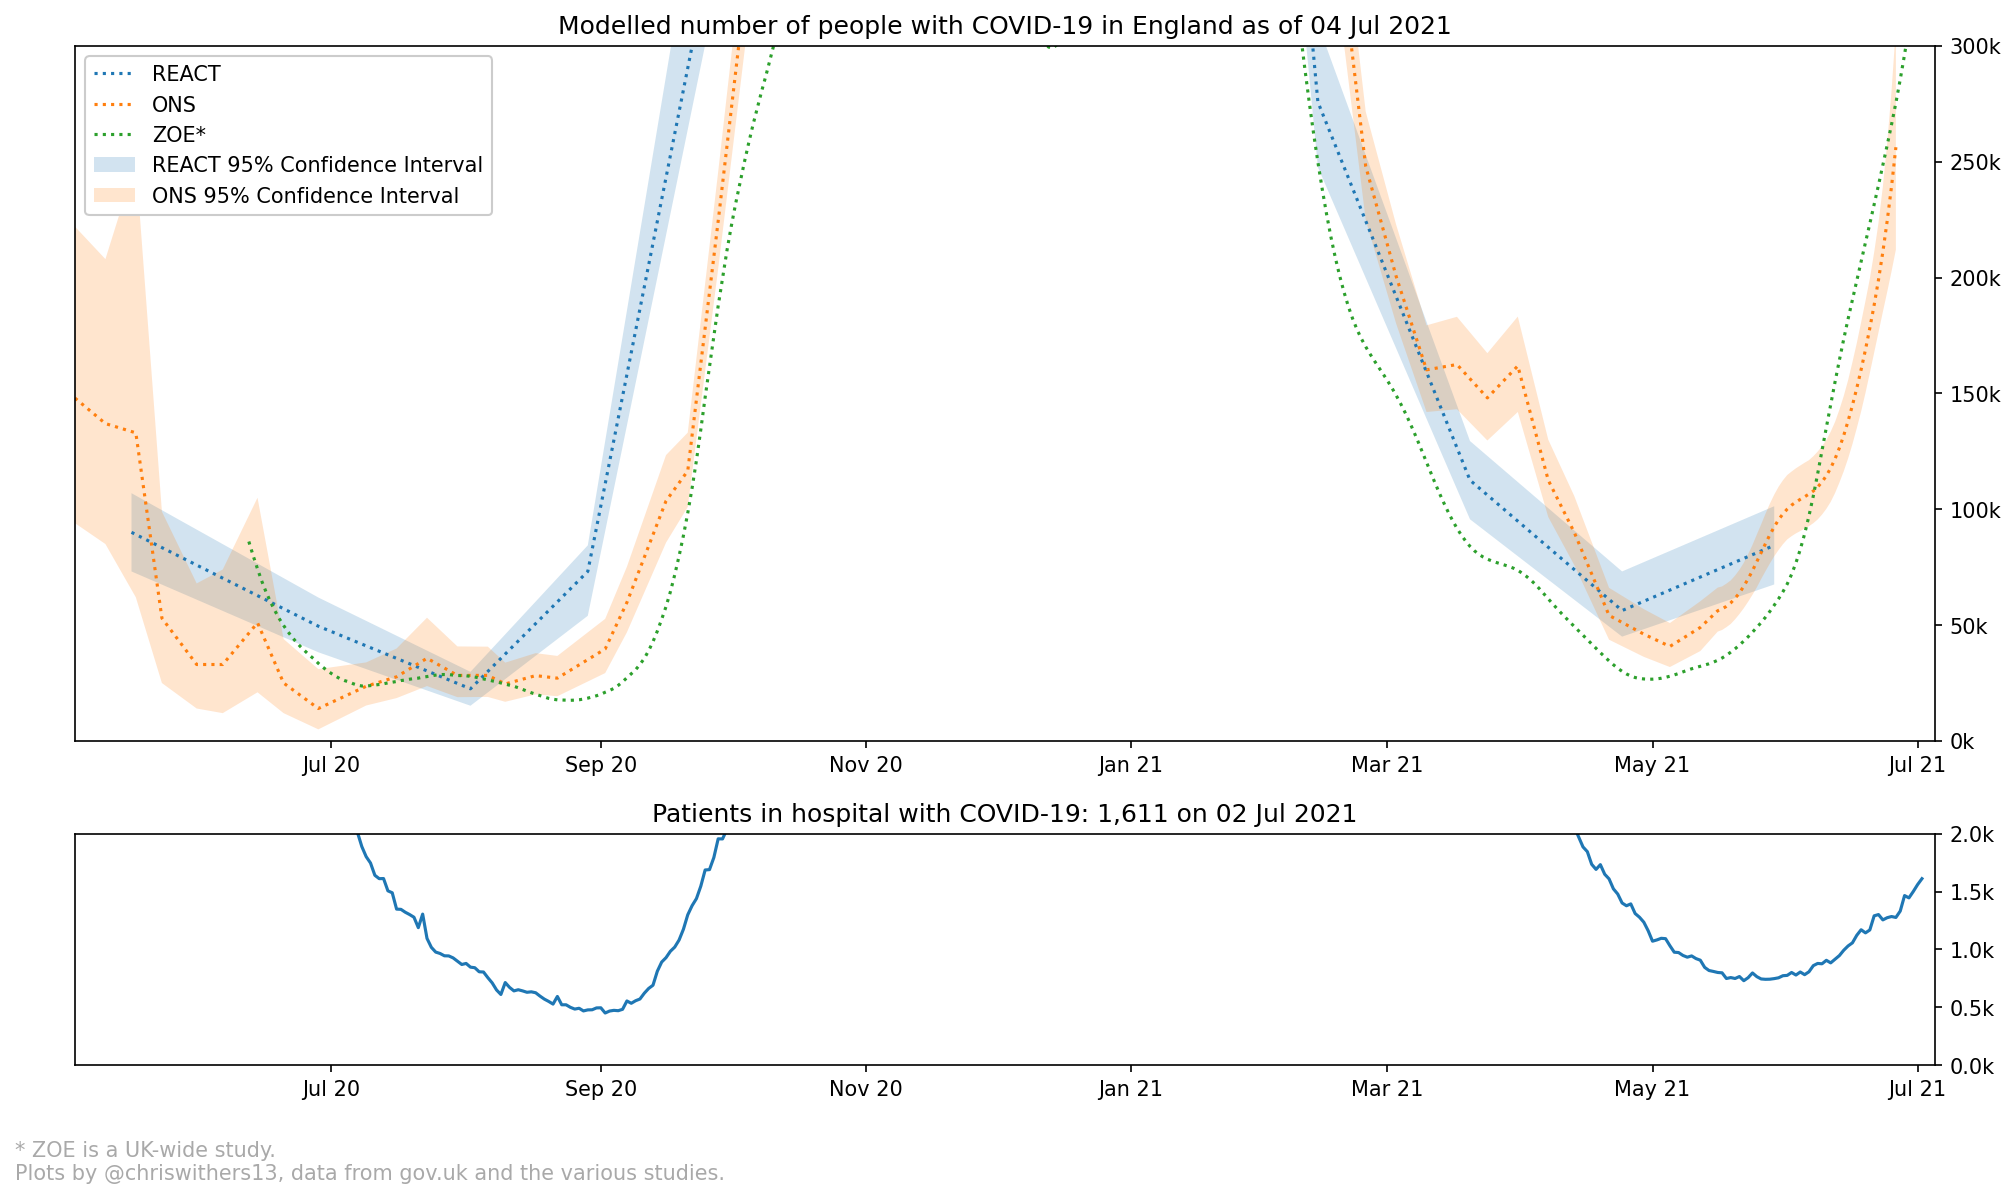

In [3]:
plot_prevalence(max_cases=300_000, max_hospital=2_000)

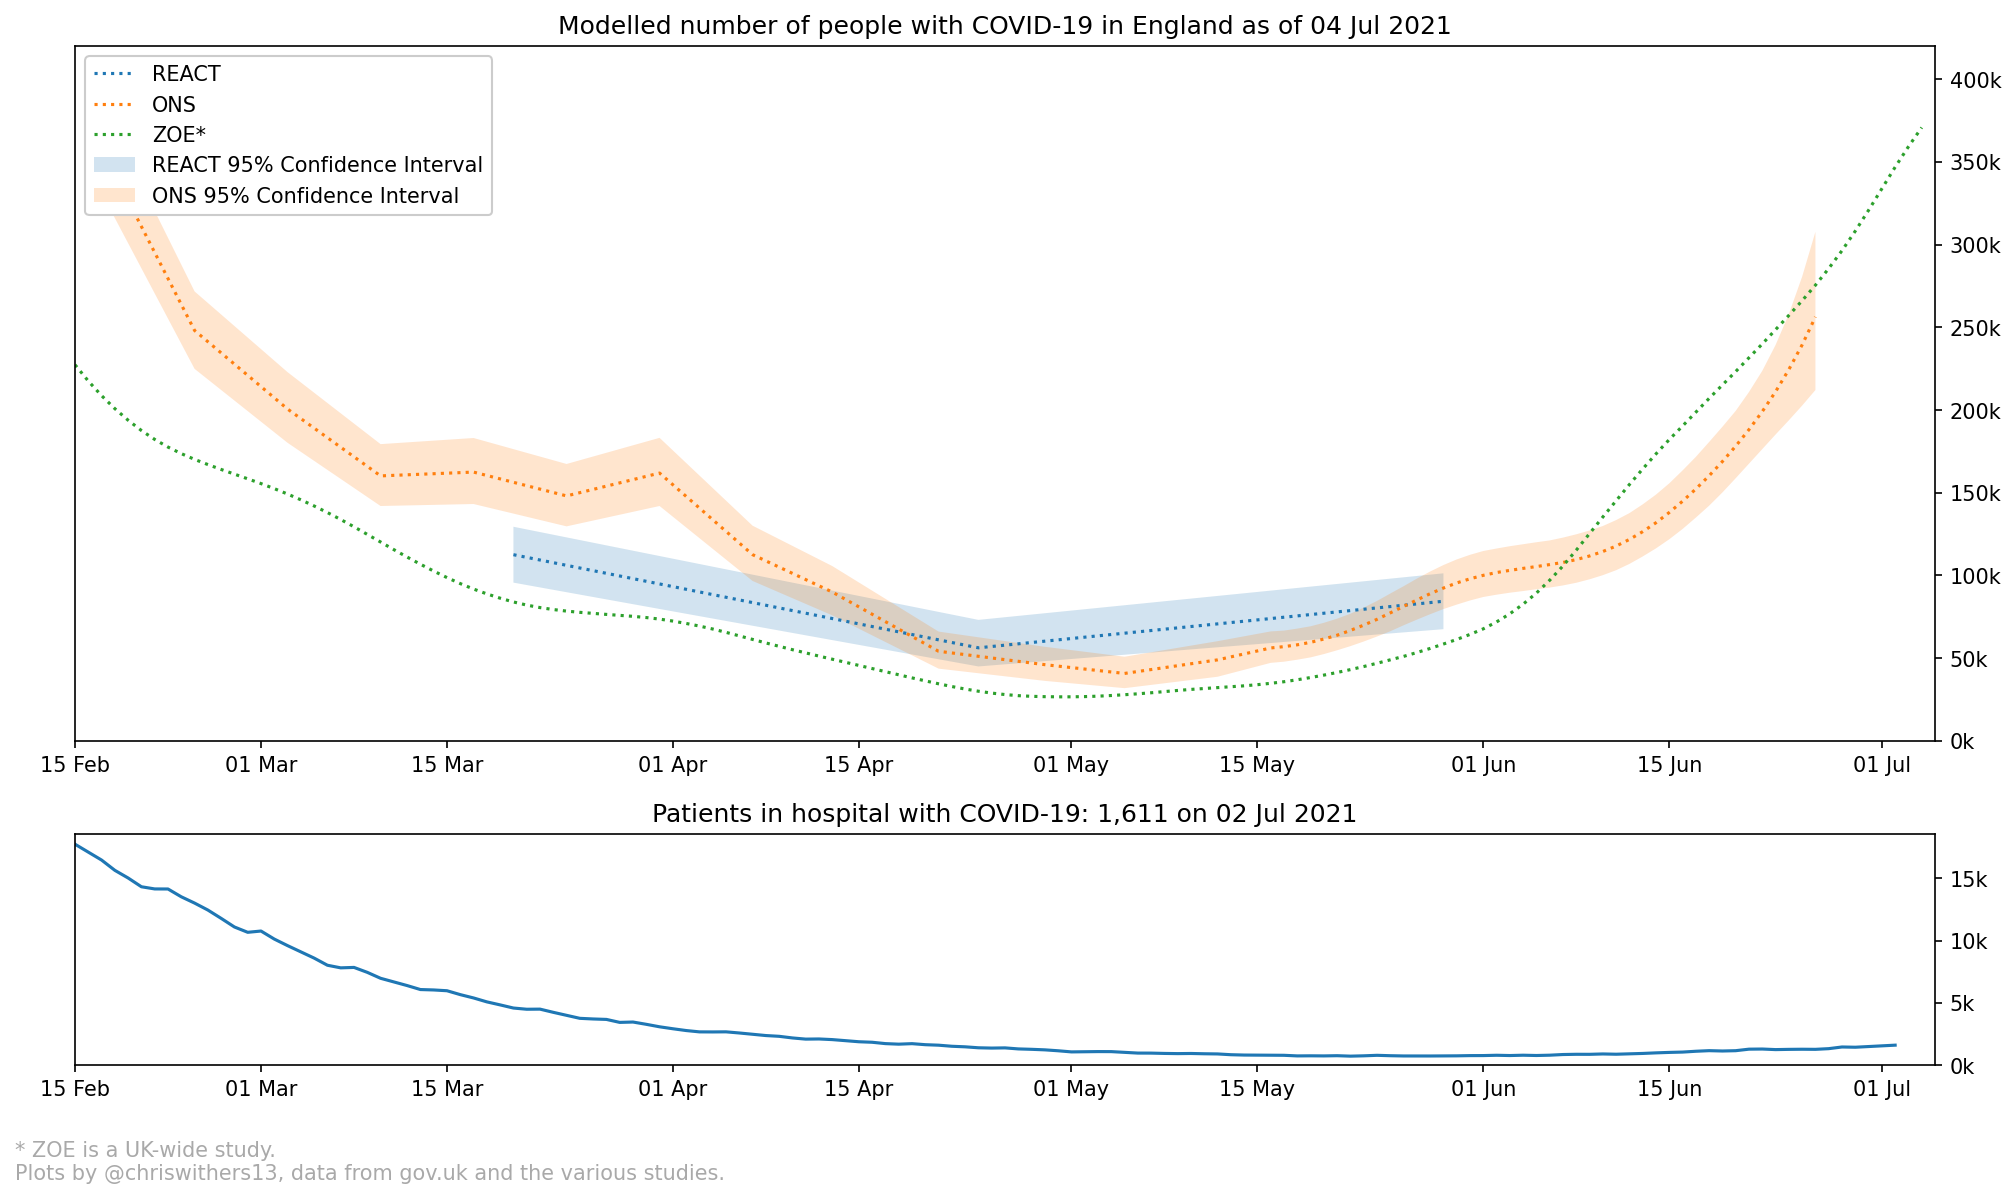

In [4]:
plot_prevalence(earliest='2021-02-15')